# 1. Generate synthetic data set
- N = 1000 observations
- J = 1000 alternatives for all observations (C_n = C)
- X = single attribute distributed Uniform(-2,1) for the first 500 alternatives and Uniform(-1,2) for the second half
- beta = generic linear taste coefficient, distributed Normal(mu=1.5, sigma=0.8) across the 1000 observations
- systematic utility = beta * X
- epsilon = error term distributed ExtremeValue(0,1)
- random utility = beta * X + epsilon
- Utility of alternative i for agent n: $$ U_{in} = V_{in} + \varepsilon_{in} = \beta_n x_{i} + \varepsilon_{in} $$

- Probability that agent n will choose alternative i: $$ L_n(i \mid \beta_n, x_n,C_n) = \frac {e^{V_{in}}} {\sum_{j \epsilon C_n} e^{V_{jn}}} $$

In [145]:
import numpy as np
import pandas as pd

In [146]:
# Generate attribute x for each of J alternatives
# Set a seed for reproducibility
np.random.seed(12)
# Start with J << 1000 to speed up runtimes
J = 50  # alternatives
Xa = 3 * np.random.rand(int(J/2)) - 2  # uniform distribution over [-2, 1]
Xb = 3 * np.random.rand(int(J/2)) - 1  # uniform distribution over [-1, 2]
X = np.concatenate((Xa, Xb))
len(X) , X[:5]

(50, array([-1.53751147,  0.22014909, -1.21005495, -0.39878182, -1.95627511]))

In [147]:
Xa.mean(), Xa.var(), Xb.mean(), Xb.var()

(-0.6588490021631214,
 0.9820474818827583,
 0.6879886567353536,
 0.6061399517798512)

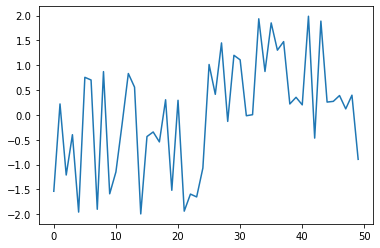

In [148]:
import matplotlib.pyplot as plt
plt.plot(X)

In [149]:
# Generate taste coefficient beta for each of N agents 
# For regular MNL, we need to use a single value, instead of a 
# distribution as Guevara & Ben-Akiva used for the mixture model
N = 1000  # agents/observations
beta = np.zeros(1000) + 1.5
# beta = 0.8 * np.random.randn(N) + 1.5
len(beta), beta[:5]

(1000, array([1.5, 1.5, 1.5, 1.5, 1.5]))

In [150]:
pd.DataFrame(beta).describe()

,0
count,1000.0
mean,1.5
std,0.0
min,1.5
25%,1.5
50%,1.5
75%,1.5
max,1.5


In [151]:
X.shape, N

((50,), 1000)

In [152]:
# Generate probability matrix for N agents choosing among J alternatives
def probs(n):
    ''' 
    Return list of J probabilities for agent n
    '''
    b = beta[n]
    exps = [np.exp(b*x) for x in X]
    sum_exps = np.sum(exps)
    return [exp/sum_exps for exp in exps]


P = np.array([probs(n) for n in range(N)])
print(P.shape)

(1000, 50)


In [153]:
# Check that each row sums to 1
print(np.sum(P, axis=1)[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [154]:
# Simulate a choice from J alternatives for each of N agents
C = [np.random.choice(range(J)) for p in P]
len(C), C[:10]

(1000, [5, 43, 32, 43, 18, 45, 6, 27, 34, 38])

# Now we have data:
* N agents/observations with true taste coefficients in array "beta"
* J alternatives with single attributes in array "X"
* N choice outcomes in array "C"

# 2. Estimate beta without sampling, using PyLogit MNL

In [155]:
import pylogit
from collections import OrderedDict

In [156]:
# Set up an estimation dataset in long format
d = [[n, i, int(C[n]==i), X[i]] for n in range(N) for i in range(J)]
print(len(d))

50000


In [157]:
pd.DataFrame(d).shape

(50000, 4)

In [158]:
df = pd.DataFrame(d, columns=['obs_id', 'alt_id', 'choice', 'x'])
df.head()

,obs_id,alt_id,choice,x
0,0,0,0,-1.537511
1,0,1,0,0.220149
2,0,2,0,-1.210055
3,0,3,0,-0.398782
4,0,4,0,-1.956275


In [159]:
df.describe()

,obs_id,alt_id,choice,x
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,499.500000,24.500000,0.020000,0.014570
std,288.677877,14.431014,0.140001,1.116965
min,0.000000,0.000000,0.000000,-1.993222
25%,249.750000,12.000000,0.000000,-0.894495
50%,499.500000,24.500000,0.000000,0.220035
75%,749.250000,37.000000,0.000000,0.832675
max,999.000000,49.000000,1.000000,1.985414


In [160]:
# Set up model spec
spec = OrderedDict([ ('x', [range(J)]) ])

labels = OrderedDict([ ('x', ['beta_x']) ])

In [161]:
%%time
m = pylogit.create_choice_model(data = df, 
                                alt_id_col = 'alt_id', 
                                obs_id_col = 'obs_id', 
                                choice_col = 'choice', 
                                specification = spec, 
                                model_type = "MNL", 
                                names = labels)

m.fit_mle(init_vals = np.array([0]))

Log-likelihood at zero: -3,912.0230
Initial Log-likelihood: -3,912.0230
Estimation Time for Point Estimation: 0.03 seconds.
Final log-likelihood: -3,912.0109


/home/danph/anaconda3/envs/dev/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


CPU times: user 466 ms, sys: 365 ms, total: 830 ms
Wall time: 568 ms


In [162]:
m.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                1,000
Model:             Multinomial Logit Model   Df Residuals:                      999
Method:                                MLE   Df Model:                            1
Date:                     Wed, 09 Jun 2021   Pseudo R-squ.:                   0.000
Time:                             15:06:02   Pseudo R-bar-squ.:              -0.000
AIC:                             7,826.022   Log-Likelihood:             -3,912.011
BIC:                             7,830.929   LL-Null:                    -3,912.023
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta_x         0.0044      0.028      0.156      0.876      -0.051       0.060
==============================================================================
"""

# 2.2 Try Biogeme

In [165]:
X.shape, N, J, len(C)

((50,), 1000, 50, 1000)

In [167]:
X

array([-1.53751147,  0.22014909, -1.21005495, -0.39878182, -1.95627511,
        0.75624102,  0.70214456, -1.89973572,  0.87084801, -1.58837204,
       -1.14851494, -0.18175045,  0.83267541,  0.55820662, -1.9932223 ,
       -0.43632192, -0.3438871 , -0.54386776,  0.30440246, -1.51784974,
        0.29368135, -1.93757061, -1.59436946, -1.65118095, -1.07030725,
        1.01435794,  0.41368933,  1.44850489, -0.13123965,  1.19937793,
        1.10786707, -0.01729157,  0.00394259,  1.93417424,  0.87374634,
        1.85094057,  1.30242695,  1.47502776,  0.21992091,  0.35392523,
        0.20189488,  1.98541448, -0.46730747,  1.88779071,  0.25775081,
        0.27215734,  0.38944661,  0.12116945,  0.3965243 , -0.89449522])

# 3. Try with UrbanSim MNL instead of PyLogit

In [117]:
from urbansim.models import MNLDiscreteChoiceModel

In [118]:
# Choosers should be a DataFrame of characteristics, with index as identifier
d = [[n, C[n]] for n in range(N)]
choosers = pd.DataFrame(d, columns=['id', 'choice']).set_index('id')
len(choosers)

1000

In [119]:
# Alternatives should be a DataFrame of characteristics, with index as identifier
d = [[i, X[i]] for i in range(J)]
alts = pd.DataFrame(d, columns=['id', 'x']).set_index('id')
len(alts)

50

In [120]:
%%time

# It seems like this implementation *requires* us to sample the alternatives, 
# so here i'm estimating the model with J-1 alts

m = MNLDiscreteChoiceModel(model_expression = 'x',
                           sample_size = J-1)

m.fit(choosers = choosers,
      alternatives = alts,
      current_choice = 'choice')

m.report_fit()

Null Log-liklihood: -3891.820
Log-liklihood at convergence: -3891.806
Log-liklihood Ratio: 0.000

+-----------+-------------+------------+---------+
| Component | Coefficient | Std. Error | T-Score |
+-----------+-------------+------------+---------+
| x         |    0.005    |   0.028    |  0.172  |
+-----------+-------------+------------+---------+
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 101 ms


# 4. MNL, sampling alternatives without correction

In [122]:
# (NB - with random sampling, no correction is needed) 
# In the estimation dataset, for each observation include a row for the
# chosen alternative, plus K-1 other alternatives sampled randomly
# without replacement, where K < J.

In [125]:
K = 3

def alts(obs_id):
    """
    Sample alternatives for observation `obs_id`. Expects `J` total
    alts, `K` sampled alts, list `C` of choice outcomes. Returns list 
    of K alt id's including the chosen one.
    """
    chosen = C[obs_id]  # id of chosen alternative
    unchosen = [i for i in range(J) if chosen != i]  # id's of J-1 unchosen alts
    sample_unchosen = np.random.choice(unchosen, size=K-1, replace=False)
    return [chosen] + sample_unchosen.tolist()

alts(0)

[5, 12, 21]

In [126]:
# Set up the estimation dataset
d = [[n, i, int(C[n]==i), X[i]] for n in range(N) for i in alts(n)]
len(d)

3000

In [128]:
df = pd.DataFrame(d, columns=['obs_id', 'alt_id', 'choice', 'x'])
df.head()

,obs_id,alt_id,choice,x
0,0,5,1,0.756241
1,0,3,0,-0.398782
2,0,30,0,1.107867
3,1,43,1,1.887791
4,1,29,0,1.199378


In [129]:
df.describe()

,obs_id,alt_id,choice,x
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,499.500000,24.189000,0.333333,-0.010257
std,288.723115,14.257058,0.471483,1.119003
min,0.000000,0.000000,0.000000,-1.993222
25%,249.750000,12.000000,0.000000,-0.894495
50%,499.500000,24.000000,0.000000,0.219921
75%,749.250000,36.000000,1.000000,0.832675
max,999.000000,49.000000,1.000000,1.985414


In [130]:
# Same model spec as before

spec = OrderedDict([
        ('x', [range(J)])
    ])

labels = OrderedDict([
        ('x', ['beta_x'])
    ])

In [132]:
%%time
m = pylogit.create_choice_model(data = df, 
                                alt_id_col = 'alt_id', 
                                obs_id_col = 'obs_id', 
                                choice_col = 'choice', 
                                specification = spec, 
                                model_type = "MNL", 
                                names = labels)

m.fit_mle(init_vals = np.array([0]))

Log-likelihood at zero: -1,098.6123
Initial Log-likelihood: -1,098.6123
Estimation Time for Point Estimation: 0.01 seconds.
Final log-likelihood: -1,098.0775
CPU times: user 45.2 ms, sys: 22.7 ms, total: 67.9 ms
Wall time: 61.5 ms


/home/danph/anaconda3/envs/dev/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


In [133]:
m.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                1,000
Model:             Multinomial Logit Model   Df Residuals:                      999
Method:                                MLE   Df Model:                            1
Date:                     Wed, 09 Jun 2021   Pseudo R-squ.:                   0.000
Time:                             14:52:27   Pseudo R-bar-squ.:              -0.000
AIC:                             2,198.155   Log-Likelihood:             -1,098.077
BIC:                             2,203.063   LL-Null:                    -1,098.612
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta_x         0.0353      0.034      1.033      0.301      -0.032       0.102
==============================================================================
"""

# Run 1000x with different samples

In [134]:
def estimate_beta():
    d = [[n, i, int(C[n]==i), X[i]] for n in range(N) for i in alts(n)]
    df = pd.DataFrame(d, columns=['obs_id', 'alt_id', 'choice', 'x'])
    m = pylogit.create_choice_model(df, 'alt_id', 'obs_id', 'choice', spec, 'MNL', names=labels)
    m.fit_mle(init_vals = np.array([0]))
    return m.params.beta_x

In [135]:
%%capture
beta = []
for i in range(1000):
    beta.append(estimate_beta())

In [139]:
pd.Series(beta).describe()

count    1000.000000
mean        0.003964
std         0.018123
min        -0.052304
25%        -0.008798
50%         0.004380
75%         0.016963
max         0.067494
dtype: float64

# 5. MNL with sampling correction
Utility of alternative j: $$ V_{j} = \beta x_{j} $$

With sampling, we have to account for the restricted choice set (from Eq 6 in Guevara & Ben-Akiva 2013):

$$ V_j = \beta x_j + \ln \pi(D \mid j) $$
Where pi is the conditional probability that we would construct the choice set D given that alternative j was chosen. This goes into the likelihood function in both the numerator and denominator.

$$ L_n = \frac {exp(\beta x_i + \ln \pi(D_n \mid i))} {\sum_{j \epsilon D_n} exp(\beta x_j + \ln \pi(D_n \mid j))} $$
How to calculate pi? From the original formulation of this in McFadden 1978: "Suppose D is comprized of i plus a sample of alternatives from the set C\{i}, obtained by considering each element of this set independently, and including it with probability p. Then, the probability of D will depend solely on the number of elements K it contains."

$$ \pi(D) = p^{K-1} (1 - p)^{J-K} $$
(?? Without replacement, i think it should be the n-choose-k binomial coefficient, where n=J-1 and k=K-1)

$$ \pi(D) = {n \choose k} = \frac {(K-1)!(J-K)!} {(J-1)!} $$

In [136]:
# Add a column in the estimation data for the constant
d = [[n, i, int(C[n]==i), X[i], 1] for n in range(N) for i in alts(n)]
df = pd.DataFrame(d, columns=['obs_id', 'alt_id', 'choice', 'x', 'const'])
df.head()


,obs_id,alt_id,choice,x,const
0,0,5,1,0.756241,1
1,0,4,0,-1.956275,1
2,0,23,0,-1.651181,1
3,1,43,1,1.887791,1
4,1,0,0,-1.537511,1


In [137]:
df.describe()

,obs_id,alt_id,choice,x,const
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.0
mean,499.500000,24.154333,0.333333,0.010779,1.0
std,288.723115,14.250153,0.471483,1.132319,0.0
min,0.000000,0.000000,0.000000,-1.993222,1.0
25%,249.750000,12.000000,0.000000,-0.894495,1.0
50%,499.500000,24.000000,0.000000,0.220149,1.0
75%,749.250000,36.000000,1.000000,0.832675,1.0
max,999.000000,49.000000,1.000000,1.985414,1.0


In [138]:
spec2 = OrderedDict([
        ('x', [range(J)]),
        ('const', [range(J)])
    ])

labels2 = OrderedDict([
        ('x', ['beta_x']),
        ('const', ['constant'])
    ])

In [140]:
# Try binomial formula

j=3
k=2

fact = np.math.factorial

float(fact(k-1)*fact(j-k))/fact(j-1)

0.5

In [141]:
%%time
m = pylogit.create_choice_model(data = df, 
                                alt_id_col = 'alt_id', 
                                obs_id_col = 'obs_id', 
                                choice_col = 'choice', 
                                specification = spec2, 
                                model_type = "MNL", 
                                names = labels2)

# p = float(K-1)/(J-1)
# const = np.log(p**(K-1) * (1-p)**(J-K))

const = np.log(float(fact(K-1)*fact(J-K))/fact(J-1))

# Add an initial value for the constant and constrain it to that
m.fit_mle(init_vals = np.array([0, const]), 
          constrained_pos=[1])

Log-likelihood at zero: -1,098.6123
Initial Log-likelihood: -1,098.6123
Estimation Time for Point Estimation: 0.02 seconds.
Final log-likelihood: -1,098.5629
CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 71.9 ms


/home/danph/anaconda3/envs/dev/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/danph/anaconda3/envs/dev/lib/python3.8/site-packages/pylogit/base_multinomial_cm_v2.py:1228: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.cov)),


In [142]:
print(m.get_statsmodels_summary())

                     Multinomial Logit Model Regression Results                    
Dep. Variable:                      choice   No. Observations:                1,000
Model:             Multinomial Logit Model   Df Residuals:                      998
Method:                                MLE   Df Model:                            2
Date:                     Wed, 09 Jun 2021   Pseudo R-squ.:                   0.000
Time:                             14:56:20   Pseudo R-bar-squ.:              -0.002
AIC:                             2,201.126   Log-Likelihood:             -1,098.563
BIC:                             2,210.941   LL-Null:                    -1,098.612
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta_x         0.0106         -0       -inf      0.000       0.011       0.011
constant      -7.0699        nan        nan        nan         nan         nan


# Run 1000x with different samples

In [143]:
# try binomial formula
const = np.log(float(fact(K-1)*fact(J-K))/fact(J-1))

def estimate_beta_with_correction():
    d = [[n, i, int(C[n]==i), X[i], 1] for n in range(N) for i in alts(n)]
    df = pd.DataFrame(d, columns=['obs_id', 'alt_id', 'choice', 'x', 'const'])
    m = pylogit.create_choice_model(df, 'alt_id', 'obs_id', 'choice', spec2, 'MNL', names=labels2)
    m.fit_mle(init_vals = np.array([0, const]), constrained_pos=[1])
    return m.params.beta_x

In [144]:
%%capture
beta = []
for i in range(1000):
    beta.append(estimate_beta_with_correction())

LinAlgError: singular matrix